In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import nest
import nest.voltage_trace
import nest.raster_plot

import numpy as np

import time
from numpy import exp

plt.rcParams['figure.dpi'] = 500

In [2]:
def brunel_network(simtime = 300., g = 5., eta = 2., epsilon = 0.1):
    
    """Random balanced network (delta synapses)
    ----------------------------------------------

    This script simulates an excitatory and an inhibitory population on
    the basis of the network used in [1]

    When connecting the network customary synapse models are used, which
    allow for querying the number of created synapses. Using spike
    detectors the average firing rates of the neurons in the populations
    are established. The building as well as the simulation time of the
    network are recorded.

    References
    ~~~~~~~~~~~~~~

    .. [1] Brunel N (2000). Dynamics of sparsely connected networks of excitatory and
           inhibitory spiking neurons. Journal of Computational Neuroscience 8,
           183-208.

    """
    
    nest.ResetKernel()
    
    ###############################################################################
    # Assigning the current time to a variable in order to determine the build
    # time of the network.

    startbuild = time.time()

    ###############################################################################
    # Assigning the simulation parameters to variables.
    
    dt = 0.1  # the resolution in ms
    # simtime = 300.0  # Simulation time in ms
    delay = 1.5  # synaptic delay in ms
    
    ###############################################################################
    # Definition of the parameters crucial for asynchronous irregular firing of
    # the neurons.
    
    #g = 5.0  # ratio inhibitory weight/excitatory weight
    #eta = 2.0  # external rate relative to threshold rate
    #epsilon = 0.1  # connection probability
    
    ###############################################################################
    # Definition of the number of neurons in the network and the number of neuron
    # recorded from
    
    order = 2500
    NE = 4 * order  # number of excitatory neurons
    NI = 1 * order  # number of inhibitory neurons
    N_neurons = NE + NI  # number of neurons in total
    N_rec = 100  # record from 50 neurons

    ###############################################################################
    # Definition of connectivity parameter
    
    CE = int(epsilon * NE)  # number of excitatory synapses per neuron
    CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
    C_tot = int(CI + CE)  # total number of synapses per neuron

    ###############################################################################
    # Initialization of the parameters of the integrate and fire neuron and the
    # synapses. The parameter of the neuron are stored in a dictionary.
    
    tauMem = 20.0  # time constant of membrane potential in ms
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {"C_m": 1.0,
                     "tau_m": tauMem,
                     "t_ref": 2.0,
                     "E_L": 0.0,
                     "V_reset": 0.0,
                     "V_m": 0.0,
                     "V_th": theta}
    J = 0.1  # postsynaptic amplitude in mV
    J_ex = J  # amplitude of excitatory postsynaptic potential
    J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

    ###############################################################################
    # Definition of threshold rate, which is the external rate needed to fix the
    # membrane potential around its threshold, the external firing rate and the
    # rate of the poisson generator which is multiplied by the in-degree CE and
    # converted to Hz by multiplication by 1000.
    
    nu_th = theta / (J * CE * tauMem)
    nu_ex = eta * nu_th
    p_rate = 1000.0 * nu_ex * CE
    
    ###############################################################################
    # Configuration of the simulation kernel by the previously defined time
    # resolution used in the simulation. Setting ``print_time`` to `True` prints the
    # already processed simulation time as well as its percentage of the total
    # simulation time.

    nest.SetKernelStatus({"resolution": dt, "print_time": True,
                          "overwrite_files": True})

    print("Building network")
    
    ###############################################################################
    # Configuration of the model ``iaf_psc_delta`` and ``poisson_generator`` using
    # ``SetDefaults``. This function expects the model to be the inserted as a
    # string and the parameter to be specified in a dictionary. All instances of
    # theses models created after this point will have the properties specified
    # in the dictionary by default.

    nest.SetDefaults("iaf_psc_delta", neuron_params)
    nest.SetDefaults("poisson_generator", {"rate": p_rate})
    
    ###############################################################################
    # Creation of the nodes using ``Create``. We store the returned handles in
    # variables for later reference. Here the excitatory and inhibitory, as well
    # as the poisson generator and two spike detectors. The spike detectors will
    # later be used to record excitatory and inhibitory spikes.

    nodes_ex = nest.Create("iaf_psc_delta", NE)
    nodes_in = nest.Create("iaf_psc_delta", NI)
    noise = nest.Create("poisson_generator")
    espikes = nest.Create("spike_detector")
    ispikes = nest.Create("spike_detector")

    ###############################################################################
    # Configuration of the spike detectors recording excitatory and inhibitory
    # spikes using ``SetStatus``, which expects a list of node handles and a list
    # of parameter dictionaries. Setting the variable ``to_file`` to `True` ensures
    # that the spikes will be recorded in a .gdf file starting with the string
    # assigned to label. Setting ``withtime`` and ``withgid`` to `True` ensures that
    # each spike is saved to file by stating the gid of the spiking neuron and
    # the spike time in one line.
    
    nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                              "withtime": True,
                              "withgid": True,
                              "to_file": False}])

    nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                              "withtime": True,
                              "withgid": True,
                              "to_file": False}])

    multimeter_ex = nest.Create("multimeter")
    voltmeter_ex = nest.Create("voltmeter", N_rec)
    nest.SetStatus(multimeter_ex, {"withtime": True, "record_from":["V_m"]})

    print("Connecting devices")
    
    ###############################################################################
    # Definition of a synapse using ``CopyModel``, which expects the model name of
    # a pre-defined synapse, the name of the customary synapse and an optional
    # parameter dictionary. The parameters defined in the dictionary will be the
    # default parameter for the customary synapse. Here we define one synapse for
    # the excitatory and one for the inhibitory connections giving the
    # previously defined weights and equal delays.

    nest.CopyModel("static_synapse", "excitatory",
                   {"weight": J_ex, "delay": delay})
    nest.CopyModel("static_synapse", "inhibitory",
                   {"weight": J_in, "delay": delay})
    
    ###############################################################################
    # Connecting the previously defined poisson generator to the excitatory and
    # inhibitory neurons using the excitatory synapse. Since the poisson
    # generator is connected to all neurons in the population the default rule
    # (# ``all_to_all``) of ``Connect`` is used. The synaptic properties are inserted
    # via ``syn_spec`` which expects a dictionary when defining multiple variables
    # or a string when simply using a pre-defined synapse.

    nest.Connect(noise, nodes_ex, syn_spec="excitatory")
    nest.Connect(noise, nodes_in, syn_spec="excitatory")

    ###############################################################################
    # Connecting the first ``N_rec`` nodes of the excitatory and inhibitory
    # population to the associated spike detectors using excitatory synapses.
    # Here the same shortcut for the specification of the synapse as defined
    # above is used.
    
    nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
    nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

    for i in range(N_rec):
        nest.Connect([voltmeter_ex[i]], [nodes_ex[i]])
    #nest.Connect(multimeter_ex, nodes_ex[:N_rec])

    print("Connecting network")

    print("Excitatory connections")

    ###############################################################################
    # Connecting the excitatory population to all neurons using the pre-defined
    # excitatory synapse. Beforehand, the connection parameter are defined in a
    # dictionary. Here we use the connection rule ``fixed_indegree``,
    # which requires the definition of the indegree. Since the synapse
    # specification is reduced to assigning the pre-defined excitatory synapse it
    # suffices to insert a string.
    
    conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

    print("Inhibitory connections")
    
    ###############################################################################
    # Connecting the inhibitory population to all neurons using the pre-defined
    # inhibitory synapse. The connection parameter as well as the synapse
    # paramtere are defined analogously to the connection from the excitatory
    # population defined above.

    conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

    ###############################################################################
    # Storage of the time point after the buildup of the network in a variable.
    
    endbuild = time.time()

    ###############################################################################
    # Simulation of the network.
    
    print("Simulating")

    nest.Simulate(simtime)
    
    ###############################################################################
    # Storage of the time point after the simulation of the network in a variable.

    endsimulate = time.time()
    
    ###############################################################################
    # Reading out the total number of spikes received from the spike detector
    # connected to the excitatory population and the inhibitory population.

    events_ex = nest.GetStatus(espikes, "n_events")[0]
    events_in = nest.GetStatus(ispikes, "n_events")[0]
    
    eventsE = nest.GetStatus(espikes, "events")[0]
    eventsI = nest.GetStatus(ispikes, "events")[0]
    
    ###############################################################################
    # Calculation of the average firing rate of the excitatory and the inhibitory
    # neurons by dividing the total number of recorded spikes by the number of
    # neurons recorded from and the simulation time. The multiplication by 1000.0
    # converts the unit 1/ms to 1/s=Hz.

    rate_ex = events_ex / simtime * 1000.0 / N_rec
    rate_in = events_in / simtime * 1000.0 / N_rec
    
    ###############################################################################
    # Reading out the number of connections established using the excitatory and
    # inhibitory synapse model. The numbers are summed up resulting in the total
    # number of synapses.

    num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                    nest.GetDefaults("inhibitory")["num_connections"])

    ###############################################################################
    # Establishing the time it took to build and simulate the network by taking
    # the difference of the pre-defined time variables.
    
    build_time = endbuild - startbuild
    sim_time = endsimulate - endbuild
    
    ###############################################################################
    # Printing the network properties, firing rates and building times.

    print("Brunel network simulation (Python)")
    print("Number of neurons : {0}".format(N_neurons))
    print("Number of synapses: {0}".format(num_synapses))
    print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
    print("       Inhibitory : {0}".format(int(CI * N_neurons)))
    print("Excitatory rate   : %.2f Hz" % rate_ex)
    print("Inhibitory rate   : %.2f Hz" % rate_in)
    print("Building time     : %.2f s" % build_time)
    print("Simulation time   : %.2f s" % sim_time)

    #nest.voltage_trace.from_device(voltmeter_ex)
    #plt.clf()

    ###############################################################################
    # Plot a raster of the excitatory neurons and a histogram.
    
    nest.raster_plot.from_device(espikes, hist=True)
    #plt.clf()

    #dmm = nest.GetStatus(multimeter_ex)[0]
    #Vms = dmm["events"]["V_m"]
    #ts = dmm["events"]["times"]
    #plt.plot(ts, Vms)
    #plt.show()
    
    Vms = []
    ts = []

    for i in range(10):
        dmm = nest.GetStatus([voltmeter_ex[i]])[0]
        Vms.append(dmm["events"]["V_m"])
        ts.append(dmm["events"]["times"])
        
    return Vms, ts, eventsE, eventsI

Building network
Connecting devices
Connecting network
Excitatory connections
Inhibitory connections
Simulating
Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637700
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory rate   : 31.90 Hz
Inhibitory rate   : 32.06 Hz
Building time     : 3.30 s
Simulation time   : 27.74 s


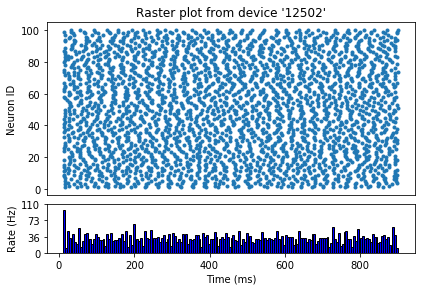

In [3]:
simtime = 900.
nbins = int(simtime)
Vms, ts, eventsE, eventsI = brunel_network(simtime, g = 5., eta = 2., epsilon = 0.1)

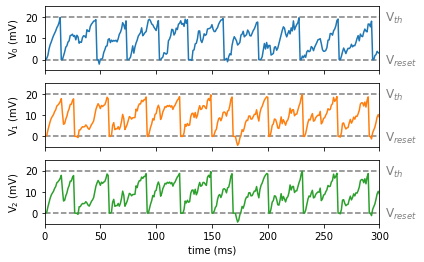

In [4]:
plt.clf()

ax1 = plt.subplot(311)
plt.axhline(0, color='tab:grey', linestyle='--')
plt.axhline(20, color='tab:grey', linestyle='--')
plt.plot(ts[0], Vms[0], color='tab:blue')
plt.xlim(0, 300)
plt.ylim(-5, 25)
plt.text(305, -2, "V$_{reset}$", color='tab:grey', fontsize=12)
plt.text(305, 18, "V$_{th}$", color='tab:grey', fontsize=12)
plt.ylabel('V$_0$ (mV)')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex=ax1, sharey=ax1)
plt.axhline(0, color='tab:grey', linestyle='--')
plt.axhline(20, color='tab:grey', linestyle='--')
plt.plot(ts[1], Vms[1], color='tab:orange')
plt.text(305, -2, "V$_{reset}$", color='tab:grey', fontsize=12)
plt.text(305, 18, "V$_{th}$", color='tab:grey', fontsize=12)
plt.ylabel('V$_1$ (mV)')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.axhline(0, color='tab:grey', linestyle='--',)
plt.axhline(20, color='tab:grey', linestyle='--')
plt.plot(ts[1], Vms[1], color='tab:green')
plt.text(305, -2, "V$_{reset}$", color='tab:grey', fontsize=12)
plt.text(305, 18, "V$_{th}$", color='tab:grey', fontsize=12)
plt.ylabel('V$_2$ (mV)')
plt.xlabel('time (ms)')
plt.show()

<Figure size 432x288 with 0 Axes>

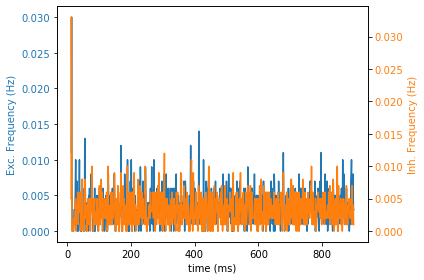

In [5]:
# counts, bins = np.histogram(eventsE['times'], bins=nbins)
# plt.plot(range(1,301), counts/1000)
# counts, bins = np.histogram(eventsI['times'], bins=nbins)
# plt.plot(range(1,301), counts/1000)
# plt.xlim(0, 300)
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('time (ms)')
# plt.show()

plt.clf()

fig, ax1 = plt.subplots()

counts, bins = np.histogram(eventsE['times'], bins=nbins)
color = 'tab:blue'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('Exc. Frequency (Hz)', color=color)
ax1.plot(bins[:-1], counts/1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
counts, bins = np.histogram(eventsI['times'], bins=nbins)
color = 'tab:orange'
ax2.set_ylabel('Inh. Frequency (Hz)', color=color)  # we already handled the x-label with ax1
ax2.plot(bins[:-1], counts/1000, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<Figure size 432x288 with 0 Axes>

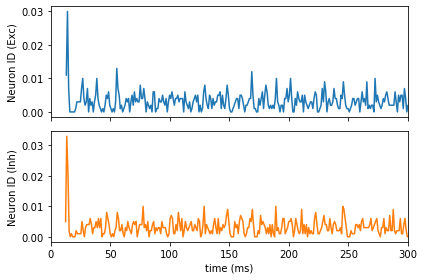

In [6]:
plt.clf()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

ax[0].set_ylabel('Neuron ID (Exc)')
counts, bins = np.histogram(eventsE['times'], bins=nbins)
ax[0].plot(bins[:-1], counts/1000, color='tab:blue')

ax[1].set_ylabel('Neuron ID (Inh)')
ax[1].set_xlabel('time (ms)')
ax[1].set_xlim(0, 300)
counts, bins = np.histogram(eventsI['times'], bins=nbins)
ax[1].plot(bins[:-1], counts/1000, color='tab:orange')

fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

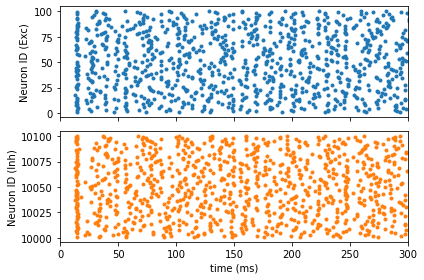

In [7]:
plt.clf()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

ax[0].set_ylabel('Neuron ID (Exc)')
ax[0].plot(eventsE['times'], eventsE['senders'], '.', color='tab:blue')

ax[1].set_ylabel('Neuron ID (Inh)')
ax[1].set_xlabel('time (ms)')
ax[1].set_xlim(0, 300)
ax[1].plot(eventsI['times'], eventsI['senders'], '.', color='tab:orange')

fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

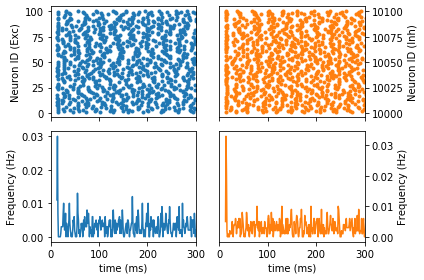

In [8]:
plt.clf()

fig, ax = plt.subplots(2, 2, sharex=True, sharey=False)

ax[0,0].set_xlim(0, 300)
ax[0,0].set_ylabel('Neuron ID (Exc)')
ax[0,0].plot(eventsE['times'], eventsE['senders'], '.', color='tab:blue')

ax[1,0].set_xlim(0, 300)
ax[1,0].set_xlabel('time (ms)')
ax[1,0].set_ylabel('Frequency (Hz)')
counts, bins = np.histogram(eventsE['times'], bins=nbins)
ax[1,0].plot(bins[:-1], counts/1000, color='tab:blue')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].set_ylabel('Neuron ID (Inh)')
ax[0,1].yaxis.tick_right()
ax[0,1].set_xlim(0, 300)
ax[0,1].plot(eventsI['times'], eventsI['senders'], '.', color='tab:orange')

ax[1,1].yaxis.set_label_position("right")
ax[1,1].set_ylabel('Frequency (Hz)')
ax[1,1].yaxis.tick_right()
ax[1,1].set_xlabel('time (ms)')
ax[1,1].set_xlim(0, 300)
counts, bins = np.histogram(eventsI['times'], bins=nbins)
ax[1,1].plot(bins[:-1], counts/1000, color='tab:orange')

fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

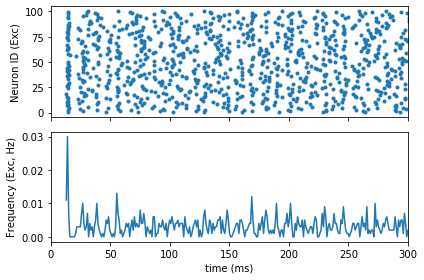

In [9]:
plt.clf()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

ax[0].set_xlim(0, 300)
ax[0].set_ylabel('Neuron ID (Exc)')
ax[0].plot(eventsE['times'], eventsE['senders'], '.', color='tab:blue')

ax[1].set_xlim(0, 300)
ax[1].set_ylabel('Frequency (Exc, Hz)')
ax[1].set_xlabel('time (ms)')
counts, bins = np.histogram(eventsE['times'], bins=nbins)
ax[1].plot(bins[:-1], counts/1000, color='tab:blue')

fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

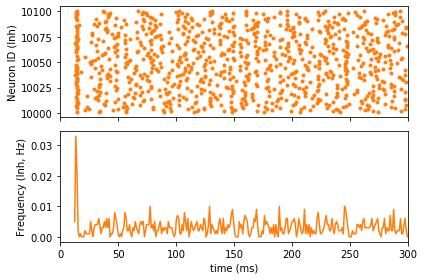

In [10]:
plt.clf()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

ax[0].set_xlim(0, 300)
ax[0].set_ylabel('Neuron ID (Inh)')
ax[0].plot(eventsI['times'], eventsI['senders'], '.', color='tab:orange')

ax[1].set_ylabel('Frequency (Inh, Hz)')
ax[1].set_xlabel('time (ms)')
ax[1].set_xlim(0, 300)
counts, bins = np.histogram(eventsI['times'], bins=nbins)
ax[1].plot(bins[:-1], counts/1000, color='tab:orange')

fig.tight_layout()
plt.show()